In [161]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize,fsolve,root_scalar
from scipy.stats import norm
import matplotlib.pyplot as plt


In [162]:
df = pd.read_excel('spx_quotedata20220308_all.xlsx')
pd.set_option('display.max_columns', 25)
df["Expiration Date"] = pd.to_datetime(df["Expiration Date"])
print(df.head())


  Expiration Date                Calls  Last Sale  Net     Bid     Ask  \
0      2022-03-09  SPXW220309C03000000       0.00  0.0  1151.7  1168.9   
1      2022-03-09  SPXW220309C03200000       0.00  0.0   951.7   969.1   
2      2022-03-09  SPXW220309C03300000       0.00  0.0   851.2   869.3   
3      2022-03-09  SPXW220309C03400000       0.00  0.0   751.7   769.1   
4      2022-03-09  SPXW220309C03500000     735.06  0.0   651.2   669.4   

   Volume      IV   Delta  Gamma  Open Interest  Strike                 Puts  \
0       0  4.3394  1.0000    0.0              0    3000  SPXW220309P03000000   
1       0  3.6439  0.9999    0.0              0    3200  SPXW220309P03200000   
2       0  3.3092  0.9999    0.0              0    3300  SPXW220309P03300000   
3       0  2.9763  0.9998    0.0              0    3400  SPXW220309P03400000   
4       0  2.6471  0.9998    0.0             10    3500  SPXW220309P03500000   

   Last Sale.1  Net.1  Bid.1  Ask.1  Volume.1    IV.1  Delta.1  Gamma.1  \

In [163]:
# Call price as middle of bid and ask
df["Mid"] = (df["Bid"] + df["Ask"]) / 2

# Put price
df["Mid.1"] = (df["Ask.1"] + df["Bid.1"])/2

S0 = 4170.7002

# List of unique maturities
maturities = df["Expiration Date"].unique()

# Define model function as call put indentity
def model(x,*args):
    S0,df_mat = args
    call_put_identity = df_mat["Mid"] - df_mat["Mid.1"] - (x[0] * S0 - x[1] * df_mat["Strike"])
    return call_put_identity.values

# Define squared deviation function
def squared_deviation(x,*args):
    call_put_indentities = model(x,*args)
    return np.sum((call_put_indentities- np.mean(call_put_indentities))**2)

B0 = [0.9]
D0 = [0.9]
for maturity in maturities:
    #Ensure that we have positive zero coupon bond prices and dividend discount factors
    df_mat = df[df["Expiration Date"] == maturity]
    cons = [
    

        # Add constraint to ensure that the sum of the call put identities is close to 0, necessary for the optimization to converge
        {'type': 'eq', 'fun': lambda x:  np.sum(model(x,S0,df_mat)) }
    ]   

    
    # Minimize squared deviation
    m = minimize(squared_deviation,[D0[-1],B0[-1]],args=(S0,df_mat),constraints=cons)

    D0.append(m.x[0])
    B0.append(m.x[1])

term_structure = pd.DataFrame({"Maturity":maturities,"D0":D0[1:],"B0":B0[1:]})

term_structure



,Maturity,D0,B0
0,2022-03-09,0.997496,0.999965
1,2022-03-11,0.997462,1.000079
2,2022-03-14,0.997263,1.000150
3,2022-03-16,0.997030,0.999847
4,2022-03-18,0.996945,0.999927
5,2022-03-21,0.997252,1.000222
6,2022-03-23,0.997327,1.000346
7,2022-03-25,0.996831,0.999867
8,2022-03-28,0.996913,0.999969
9,2022-03-30,0.996952,1.000063


In [164]:
term_structure["Forward Prices"] = S0 * term_structure["D0"] / term_structure["B0"]

$$
S(T) = S_0 \exp\left( \int_0^T \left( r(t) - q(t) - \frac{1}{2} \sigma(t)^2 \right) dt + \int_0^T \sigma(t) dW(t) \right)
$$

However, since \( \sigma(t) \) is a piecewise function, we can express it as:

$$
\int_0^T \sigma(t) dt = \sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt
$$

Moreover, \( \sigma_i(t) \) is constant on the intervals \([T_{i-1}, T_{i}]\), so we have:

$$
\sum_{i=1}^{n} \int_{T_{i-1}}^{T_i} \sigma_i(t) dt = \sum_{i=1}^{n} \sigma_i (T_{i}-T_{i-1})
$$

And we can express the discount factors as:

$$
\exp\left(-\int_0^T r(t) dt\right) = B(0,T)
$$

$$
\exp\left(-\int_0^T q(t) dt\right) = D(0,T)
$$

This leads us to:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

Now, the payoff for a European call option is given by:

$$
C = \mathbb{E}_{\beta} \left[\max(S(T) - K, 0) \exp\left(-\int_0^T r(t) dt \right)\right]
$$

This can be rewritten as:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta} \left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{E}_{\beta} \left[\mathbb{I}(S(T) > K)\right]
$$

Which simplifies to:

$$
C = \exp\left(-\int_0^T r(t) dt\right) \mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] - \exp\left(-\int_0^T r(t) dt\right) K \mathbb{P}_{\beta}(S(T) > K)
$$

Now, using the properties of the normal distribution, we have:

$$
\mathbb{P}_{\beta}(S(T) > K) = \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) - \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Next, we observe that:

$$
\frac{S(T)}{S(0)} \cdot \frac{D(0,T)}{B(0,T)} = \exp\left(-\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i \int_{T_{i-1}}^{T_i} dW(t)\right)
$$

This represents an exponential martingale. By applying Girsanov's theorem, we can change the measure from:

$$
\mathbb{P} \quad \text{to} \quad \mathbb{Q}
$$

We then have:

$$
W_Q(T_{i}) - W_Q(T_{i-1}) = W(T_{i}) - W(T_{i-1}) - \sigma_i (T_{i}-T_{i-1})
$$

Consequently, \( S(T) \) becomes:

$$
S(T) = S(0) \frac{D(0,T)}{B(0,T)} \exp\left(+\frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1}) + \sum_{i=1}^{n} \sigma_i (W_Q(T_{i}) - W_Q(T_{i-1}))\right)
$$

Thus, we find:

$$
\mathbb{E}_{\beta}\left[S(T) \mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{E}_{Q}\left[\mathbb{I}(S(T) > K)\right] = \frac{S(0)D(0,T)}{B(0,T)} \mathbb{P}_{Q}(S(T) > K)
$$

And we express this as:

$$
= \frac{S(0)D(0,T)}{B(0,T)} \Phi\left(\frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) + \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}\right)
$$

Finally, we arrive at the expression for the call option price:

$$
C = S(0) D(0,T) N(h_1) - K B(0,T) N(h_2)
$$

Where \( h_{1,2} \) are given by:

$$
h_{1,2} = \frac{\ln\left(\frac{S(0)}{K}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) \pm \frac{1}{2} \sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}{\sqrt{\sum_{i=1}^{n} \sigma_i^2 (T_{i}-T_{i-1})}}
$$


In [165]:

for _, row in term_structure.iterrows():
    df_filtered = df[df['Expiration Date'] == row['Maturity']]
    closest_value = df_filtered.iloc[(df_filtered['Strike'] - row['Forward Prices']).abs().argsort()[:1]]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Closest Strike'] = closest_value['Strike'].values[0]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Call Bid'] = closest_value['Bid'].values[0]
    term_structure.loc[term_structure['Maturity'] == row['Maturity'], 'Call Ask'] = closest_value['Ask'].values[0]





def find_sigma_i(x,*args):
    S0,maturity,sigma_i,delta_t,type = args
    sum_sigma_i = sum([sigma_i[i]**2 * delta_t[i] for i in range(len(sigma_i))])+x[0]**2 * delta_t[-1]
    h1 = (np.log(S0 / maturity["Closest Strike"]) + np.log(maturity["D0"]/maturity["B0"]) + 0.5 * sum_sigma_i) / np.sqrt(sum_sigma_i)
    h2 = h1 - np.sqrt(sum_sigma_i)
    return maturity[f"Call {type}"] - (S0 * maturity["D0"] * norm.cdf(h1) - maturity["Closest Strike"] * maturity["B0"] * norm.cdf(h2))

sigma_i_bid = []
sigma_i_ask = []
Ti = [pd.Timestamp('2022-03-08')] + maturities.tolist()
delta_t = [(Ti[1]-Ti[0]).days/365]


for i in range(len(term_structure)):
    maturity = term_structure.iloc[i]
    sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
    sigma_i_ask.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_ask,delta_t,"Ask"))[0])
   
    if i < len(term_structure)-1:
        delta_t.append(int((term_structure.iloc[i+1]["Maturity"]- term_structure.iloc[i]["Maturity"]).days)/365)


print(sigma_i_bid)
print(sigma_i_ask)



[0.34189841918343594, 0.3593458074130287, 0.2535939970892459, 0.39991057756620674, 0.35425416242479624, 0.21229545651448545, 0.3330237436453545, 0.3189577914542254, 0.20778873112983023, 0.31500745361422555, 0.30628406375292816, 0.3677964382384014, 0.18908443320046503, 0.3168579876196398, 0.31366724294640363, 0.27627507938494217, 0.2516848197822497, 0.27954680015342587, 0.2723543943293364, 0.23437853595641275, 0.2662853953018736, 0.23432750463507812, 0.2656478155825405, 0.22617397532343347, 0.2603902931647231, 8.67156420136549e-06, 0.3195939042699774, -0.00016916521929495729, 0.3161589756034889, 0.23828761850318425, 0.23361000866175413, 7.001848262434569e-05, 0.2700148168494913, -0.00022434623658889848, 2.25431841134829e-05, 0.180343860622603, 0.18107864263389853, 0.10153150929114016, 0.21490879995043718, 0.20487689232816503]
[0.41327494889878663, 0.34885648268324676, 0.23777736992342138, 0.40235111380786204, 0.35607865949551154, 0.2153322198548733, 0.33251991212214316, 0.32263154284266

C:\Users\maxim\AppData\Local\Temp\ipykernel_17748\1405859326.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
C:\Users\maxim\AppData\Local\Temp\ipykernel_17748\1405859326.py:27: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  sigma_i_bid.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_bid,delta_t,"Bid"))[0])
C:\Users\maxim\AppData\Local\Temp\ipykernel_17748\1405859326.py:28: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sigma_i_ask.append(fsolve(find_sigma_i,[0.1],args=(S0,maturity,sigma_i_ask,delta_t,"Ask"))[0])


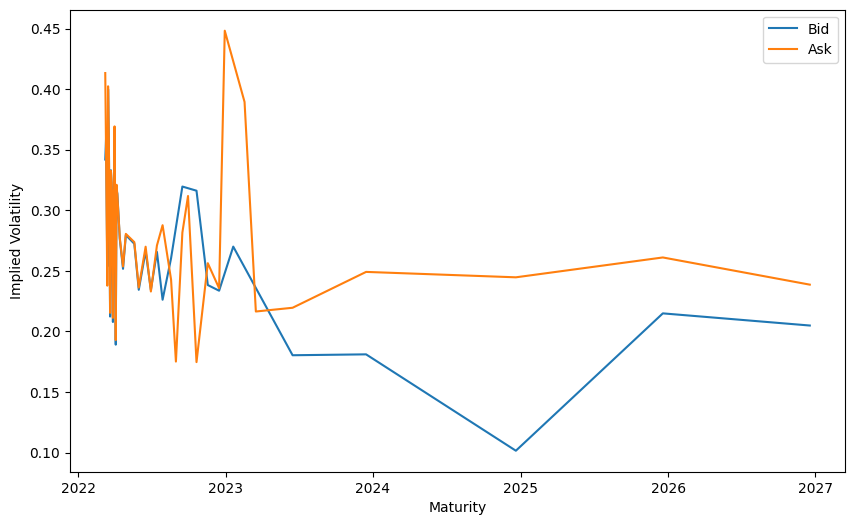

In [166]:
new_maturities_bid = []
new_maturities_ask = []
new_sigma_i_bid = []
new_sigma_i_ask = []



for i in range(len(maturities)):
    if sigma_i_bid[i] > 0.001:
        new_maturities_bid.append(maturities[i])
        new_sigma_i_bid.append(sigma_i_bid[i])
    if sigma_i_ask[i] > 0.001:
        new_sigma_i_ask.append(sigma_i_ask[i])    
        new_maturities_ask.append(maturities[i])




fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(new_maturities_bid, new_sigma_i_bid, label='Bid')
ax.plot(new_maturities_ask, new_sigma_i_ask, label='Ask')
ax.set_xlabel('Maturity')
ax.set_ylabel('Implied Volatility')
ax.legend()
plt.show()




$$
C = S(0) B(0,T) \exp(gT) N(h_1) + S(0) D(0,T)^{1-\alpha} B(0,T)^\alpha N(h_2) \exp(\frac{\alpha^2-\alpha}{2}\int_0^T\sigma(t)^2 dt)
$$

Where \( h_{1,2} \) are given by:

$$
h_1 = \frac{\left(\frac{gT}{1-\alpha}\right) - \ln\left(\frac{D(0,T)}{B(0,T)}\right) + \frac{1}{2} \int_0^T \sigma(t)^2 dt}{\sqrt{\int_0^T \sigma(t)^2 dt}}
$$

$$
h_2 = \frac{\left(-\frac{gT}{1-\alpha}\right) + \ln\left(\frac{D(0,T)}{B(0,T)}\right) + (\frac{1}{2}-\alpha) \int_0^T \sigma(t)^2 dt}{\sqrt{\int_0^T \sigma(t)^2 dt}}
$$

In [167]:
import numpy as np
from scipy.stats import norm



def payoff(g,*args):
     S0, D, B, T, alpha, sigma_square = args
     numerator = (g * T) / (1-alpha) - np.log(D / B)
     denominator = np.sqrt(sigma_square)

     h1 = norm.cdf((numerator + 0.5 * sigma_square) / denominator)
     h2 = norm.cdf((-numerator +(0.5-alpha) * sigma_square) / denominator)

     C = (S0 * (D**(1 - alpha)) * (B**alpha) * h2 *np.exp(alpha*(alpha-1)/2 * sigma_square) +
          S0 * B * np.exp(g * T) * h1 )
     return C-S0




sigma_square = 0
maturities_bid = [pd.Timestamp('2022-03-08')] + new_maturities_bid
for i in range(len(new_sigma_i_bid)):
     sigma_square += new_sigma_i_bid[i]**2 * (maturities_bid[i+1] -  maturities_bid[i]).days/365

sigma_square2 = 0   
maturities_ask = [pd.Timestamp('2022-03-08')] + new_maturities_ask
for i in range(len(new_sigma_i_ask)):
     sigma_square2 += new_sigma_i_ask[i]**2 * (maturities_ask[i+1] -  maturities_ask[i]).days/365


#sigma_square = (sigma_square + sigma_square2) / 2

sigma_square = sigma_square2

T = (Ti[-1] - Ti[0]).days/365
zcb = B0[-1]
g025 = fsolve(payoff, [0], args=(S0, D0[-1], zcb,T , 0.25, sigma_square))[0]
g05 = fsolve(payoff, [0], args=(S0, D0[-1], zcb, T, 0.5, sigma_square))[0]

g075 = fsolve(payoff, [0], args=(S0, D0[-1],zcb, T, 0.75, sigma_square))[0]
print(g025,g05,g075)




-0.02175960047881828 0.004730163397526423 0.01956000132233885


In [174]:
def portfolio_price(weights, *args):

    df = args[0]
    zcb = args[1]
    call_weights = weights[:12]
    put_weights = weights[12:24]
    zcb_weight = weights[-1]
    
    price = 0

    for i in range(12):
        if call_weights[i] > 0:
            price += call_weights[i] * df.iloc[i]["Ask"]
        else:
            price += call_weights[i] * df.iloc[i]["Bid"]
        
        if put_weights[i] > 0:
            price += put_weights[i] * df.iloc[i]["Ask.1"]
        else:
            price += put_weights[i] * df.iloc[i]["Bid.1"]
    
    return price + zcb_weight * zcb

def replicated_payoff(weights, calls, puts):
    
    call_weights = weights[:12]
    put_weights = weights[12:24]
    zcb_weight = weights[-1]
    
    return np.dot(call_weights, calls.T) + np.dot(put_weights, puts.T) + zcb_weight 

def minimize_portfolio_price(initial_weights,df, g, alpha, T, S, S0, zcb):
    strikes = df["Strike"].values
  
    calls = np.array([[max(s - strike, 0) for strike in strikes] for s in S])
    puts = np.array([[max(strike - s, 0) for strike in strikes] for s in S])

    option_payoff = np.maximum(S0 * np.exp(g * T), S0 ** alpha * S ** (1 - alpha))

    # Constraint: Penalty if the replicated payoff is smaller than the option payoff
    def payoff_constraint(weights):
        diff = replicated_payoff(weights, calls, puts) - option_payoff
        diff_sum = 0
        for i in range(len(diff)):
            diff_sum += diff[i]**2 if diff[i] < 0 else 0
        return diff_sum
           

    bounds = [(-5, 5)] * 24 + [(-5000, 5000)]  # Bounds for 24 options and 1 ZCB weight

    result = minimize(
        portfolio_price,
        initial_weights,
        args=(df,zcb),
        bounds=bounds,
        constraints={'type': 'eq', 'fun': payoff_constraint},
        method='SLSQP'
    )
    
    return result

def optimize_portfolio(g, alpha):
    strikes = df_mat["Strike"].values

    S = np.linspace(0, max(strikes)*2, 10000)
    weights = np.zeros(25)
    best_weights = np.ones(25)
    for k in range(15):
        result = np.array(minimize_portfolio_price(weights,df_mat, g, alpha, T, S, S0, zcb).x)
        # Set weights for options with Bid = 0 to 0 if negative
        result[8] = max(result[8],0)
        result[9] = max(result[9],0)
        result[10] = max(result[10],0)
        if portfolio_price(result, df_mat,zcb) < portfolio_price(best_weights, df_mat,zcb):
            best_weights = result
        if np.allclose(result, weights, rtol=1e-05, atol=1e-08):
            break
        weights = result

    return best_weights

def show_results(weights,g,alpha):
    strikes = df_mat["Strike"].values
    S = np.linspace(0, max(strikes)*2, 10000)
    calls = np.array([[max(s - strike, 0) for strike in strikes] for s in S])
    puts = np.array([[max(strike - s, 0) for strike in strikes] for s in S])
    option_payoff = np.maximum(S0 * np.exp(g * T), S0 ** alpha * S ** (1 - alpha))
    

    from scipy.optimize import differential_evolution
    def option_payoff_func(S):
        return np.maximum(S0 * np.exp(g * T), S0 ** alpha * S ** (1 - alpha))

    def replicated_payoff_func(S, weights, strikes):
        calls = np.array([max(S - strike, 0) for strike in strikes])
        puts = np.array([max(strike - S, 0) for strike in strikes])
        return replicated_payoff(weights, calls, puts)

    def difference(S, weights, strikes):
        return replicated_payoff_func(S[0], weights, strikes) - option_payoff_func(S[0])

    bounds = [(0, max(strikes) * 2)]
    result = differential_evolution(difference, bounds=bounds, args=(weights, strikes))
    min_diff = result.fun
    print(min_diff)
    
 
    weights[-1] -= min_diff if min_diff < 0 else 0
    price = portfolio_price(weights, df_mat,zcb)
    print(list(weights))
    print(price)
    replicated = replicated_payoff(weights, calls, puts)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(S, option_payoff, label='Option Payoff', color='blue')
    ax.plot(S, replicated, label='Replicated Payoff', color='orange')
    ax.legend()
    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Payoff')
    plt.title('Option Payoff vs. Replication Strategy (SSE Minimization)')
    plt.grid()
    plt.show()


In [175]:
zcb = B0[-1]  
df_mat = df[df["Expiration Date"]== "2026-12-18"].reset_index(drop=True)

-0.0012518129728960048
[0.010878329569588398, 0.21626737813029223, 0.48710387380022513, 4.7848112449503846e-06, -6.889430809041603e-07, -6.330899408776787e-06, -0.06659131616924584, 6.687640524903606e-07, 0.0, 7.59181347712205e-08, 0.0, -0.05242222113228319, -0.010873313356082983, 2.3031034548499567e-07, 1.4467878708202926e-06, 1.9607652115514168e-07, 6.419711340458212e-09, -1.742571710883837e-07, 2.3108010622947986e-08, 5.075597650818985e-06, 1.534765251972323e-07, 1.3766375341925756e-06, -5.050500218026451e-09, 0.010866566374123733, 3684.4798952802203]
4259.89604949026


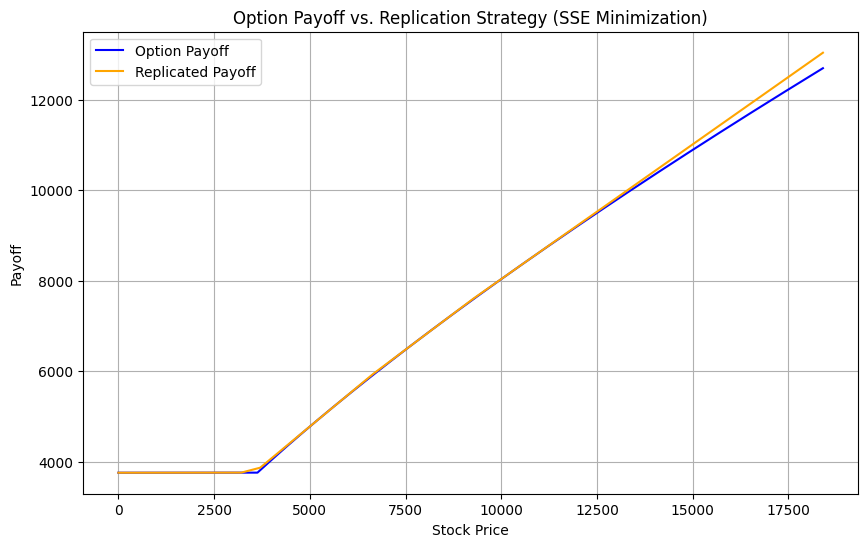

In [176]:
show_results(optimize_portfolio(g025, 0.25),g025,0.25)

-0.0008893067888493533
[-5.164107613080563e-09, 1.1010127780962557e-06, -1.50866932955117e-07, 1.3427141324356403e-09, 0.3976823422587101, 0.020191388436860445, -0.038138345694126434, -0.007487872020088691, 0.0, 0.0, 0.0, -0.06789222534354296, -3.0541977346561207e-07, -1.3475434933328107e-08, -8.06964356616352e-08, 2.373045556928459e-10, 0.00014136198322173678, 1.3834748007973877e-06, -9.418398629800034e-07, -7.514405573761331e-07, -2.438512299617225e-07, -4.710365538630471e-06, -9.565008425221546e-08, -0.000135344327869433, 4266.848139028673]
4191.913701046366


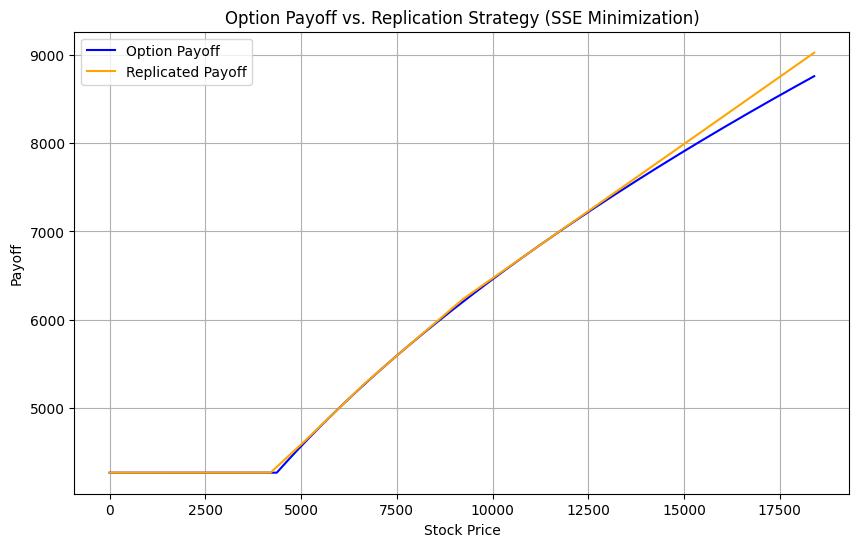

In [177]:
show_results(optimize_portfolio(g05, 0.5),g05,0.5)

In [ ]:
show_results(optimize_portfolio(g075, 0.75),g075,0.75)